## Imports

In [23]:
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
import importlib

### Loading Repo

In [24]:
!git clone -b talib-1 http://github.com/Zapy67/ATML-PA-2

Cloning into 'ATML-PA-2'...
remote: Enumerating objects: 527, done.
remote: Counting objects: 100% (199/199), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 527 (delta 128), reused 141 (delta 74), pack-reused 328 (from 1)
Receiving objects: 100% (527/527), 18.25 MiB | 35.60 MiB/s, done.
Resolving deltas: 100% (306/306), done.


In [62]:
!git pull http://github.com/Zapy67/ATML-PA-2 talib-1

remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 8 (delta 6), reused 5 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (8/8), 955 bytes | 238.00 KiB/s, done.
From http://github.com/Zapy67/ATML-PA-2
 * branch            talib-1    -> FETCH_HEAD
Updating e9e1d4a..1e7cc7e
Fast-forward
 DANN & CDAN/CDAN.py | 15 +++++++++------
 1 file changed, 9 insertions(+), 6 deletions(-)


In [25]:
%cd ATML-PA-2/

/kaggle/working/ATML-PA-2/DANN & CDAN/ATML-PA-2


In [27]:
%cd "DANN & CDAN"

/kaggle/working/ATML-PA-2/DANN & CDAN/ATML-PA-2/DANN & CDAN


In [28]:
!ls

cdan.ipynb  CDAN.py  dann.ipynb  DANN.py  train.py  utils


In [29]:
from utils.dataset import MEAN, STD, OfficeHomeDataset
import utils
import os
from torchvision.models import ResNet50_Weights

importlib.reload(utils)

<module 'utils' from '/kaggle/working/ATML-PA-2/DANN & CDAN/ATML-PA-2/DANN & CDAN/utils/__init__.py'>

### Loading Dataset

In [30]:
root_dir = '/kaggle/input/officehome/OfficeHomeDataset_10072016'
csv_file = '/kaggle/input/officehome/OfficeHomeDataset_10072016/ImageInfo.csv'

In [31]:
import torchvision.transforms as transforms
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Testing
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])


In [32]:
# transform = ResNet50_Weights.IMAGENET1K_V1.transforms()
classes = os.listdir(f"{root_dir}/Art")

In [33]:
sources = ["Art", "Real World", "Product"]
target = ["Clipart"]
source_ds = utils.dataset.OfficeHomeDataset(root_dir, csv_file, sources, train_transform)
target_ds = utils.dataset.OfficeHomeDataset(root_dir, csv_file, target, test_transform)

(15913, 2)
                                           name  \
0  D:/Dataset10072016/Art/Alarm_Clock/00001.jpg   
1  D:/Dataset10072016/Art/Alarm_Clock/00002.jpg   
2  D:/Dataset10072016/Art/Alarm_Clock/00003.jpg   
3  D:/Dataset10072016/Art/Alarm_Clock/00004.jpg   
4  D:/Dataset10072016/Art/Alarm_Clock/00005.jpg   

                                                link  
0  http://img03.deviantart.net/6533/i/2012/052/0/...  
1  http://img07.deviantart.net/a073/i/2011/214/5/...  
2  http://img08.deviantart.net/955f/i/2011/226/b/...  
3  http://img06.deviantart.net/d6fe/i/2006/177/7/...  
4  http://orig04.deviantart.net/7945/f/2013/237/b...  
(15913, 2)
                                           name  \
0  D:/Dataset10072016/Art/Alarm_Clock/00001.jpg   
1  D:/Dataset10072016/Art/Alarm_Clock/00002.jpg   
2  D:/Dataset10072016/Art/Alarm_Clock/00003.jpg   
3  D:/Dataset10072016/Art/Alarm_Clock/00004.jpg   
4  D:/Dataset10072016/Art/Alarm_Clock/00005.jpg   

                                  

In [34]:
source_loader = DataLoader(source_ds, batch_size=32, shuffle=True, num_workers=2)
target_loader = DataLoader(target_ds, batch_size=32, shuffle=True, num_workers=2)

In [35]:
def denormalize(img_tensor, mean=MEAN, std=STD):
    """Undo normalization on a single image tensor (C,H,W) → numpy (H,W,C) in [0,1]."""
    img = img_tensor.clone().cpu()
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    img = img * std + mean
    img = img.permute(1, 2, 0).clamp(0, 1)
    return img.numpy()

In [36]:
def show_images_from_dataset(dataset, n=8, title="Sample Images"):
    """
    Displays 'n' random images from the OfficeHomeDataset with class names.
    """
    plt.figure(figsize=(3 * n, 3))
    indices = torch.randperm(len(dataset))[:n]

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img = denormalize(img)
        label_name = list(dataset.class_to_idx.keys())[label]

        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(label_name, fontsize=9)
        plt.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


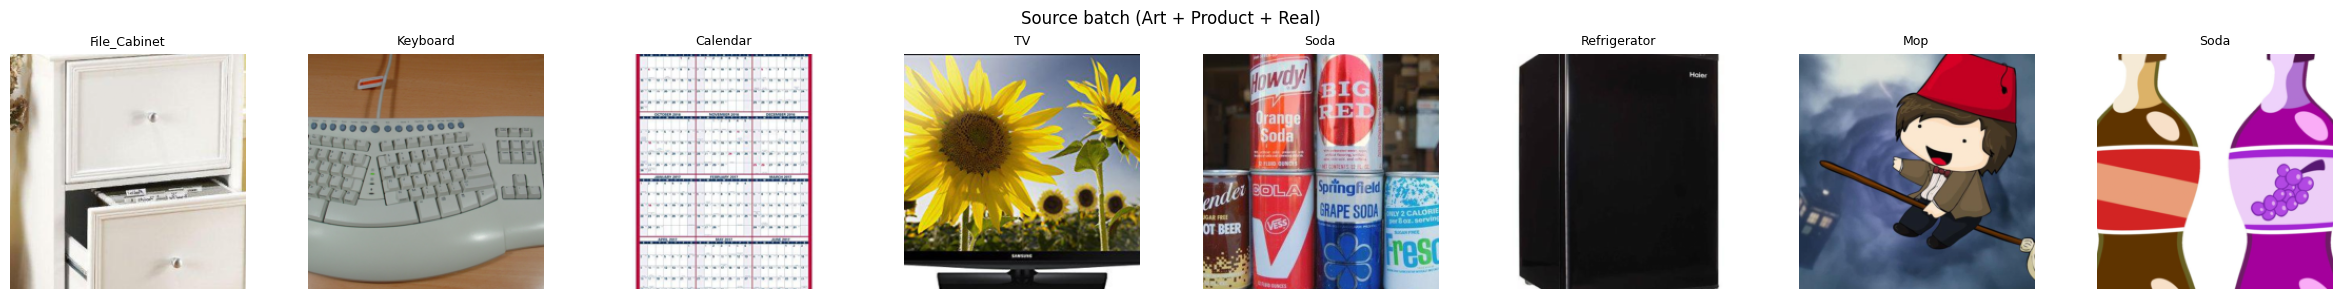

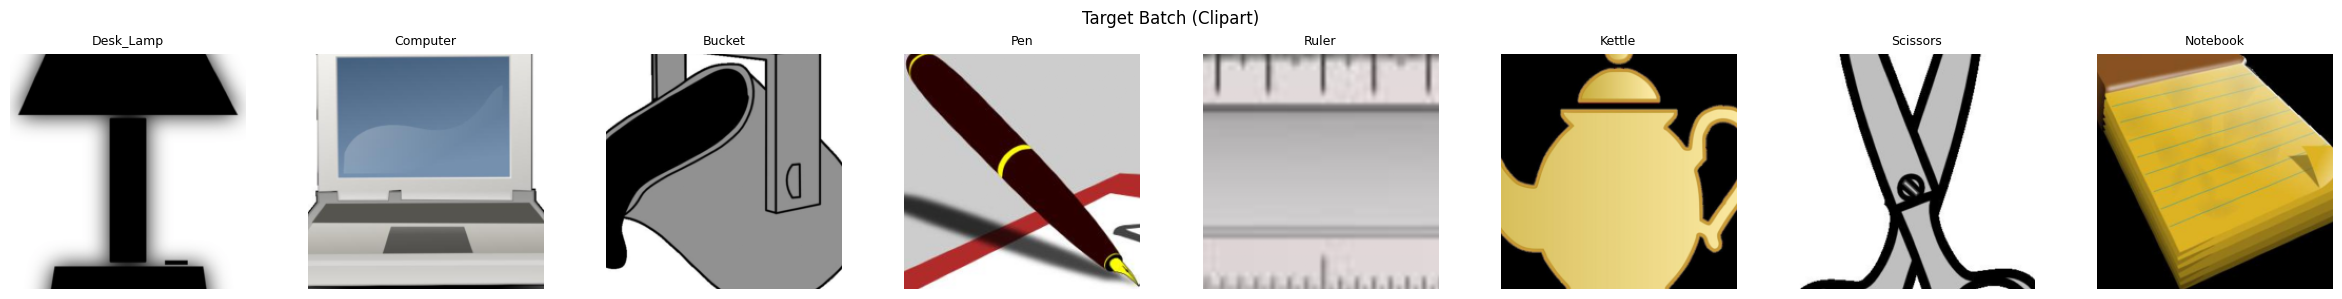

In [15]:
# show source images
show_images_from_dataset(source_ds, title="Source batch (Art + Product + Real)")
# show target images
show_images_from_dataset(target_ds, title="Target Batch (Clipart)")

## CDAN Training

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [63]:
import CDAN as cdan
importlib.reload(cdan)
importlib.reload(utils.dataset)

<module 'utils.dataset' from '/kaggle/working/ATML-PA-2/DANN & CDAN/ATML-PA-2/DANN & CDAN/utils/dataset.py'>

In [39]:
from utils.dataset import FeatureTensorDataset
from torchvision.models import resnet50, resnet18
from torchvision.models import ResNet18_Weights

In [40]:
import torch.nn as nn
class RestWrapper(nn.Module):
    """Wrap the `truncate_from(resnet, 'layer3')` module so it returns (B, D)
       and exposes output_dim attribute expected by DANN class."""
    def __init__(self, rest_module, output_dim=1024):
        super().__init__()
        self.rest = rest_module
        self.output_dim = output_dim

    def forward(self, featmap):
        out = self.rest(featmap)
        if out.dim() == 4:
            out = torch.flatten(out, 1)
        elif out.dim() == 2:
            # already flattened
            pass
        else:
            # keep guard
            out = out.view(out.size(0), -1)
        return out

In [41]:
def truncate_up_to(resnet: nn.Module, layer_name: str) -> nn.Sequential:
    seq = nn.Sequential()
    for name, module in resnet.named_children():
        seq.add_module(name, module)
        if name == layer_name:
            break
    return seq

def truncate_from(resnet: nn.Module, layer_name: str) -> nn.Sequential:
    seen = False
    seq = nn.Sequential()
    for name, module in resnet.named_children():
        if seen and name != 'fc':    # exclude final fc
            seq.add_module(name, module)
        if name == layer_name:
            seen = True
    return seq

def freeze_until(resnet: nn.Module, layer_name: str):
    freeze = True
    for name, module in resnet.named_children():
        if freeze:
            for p in module.parameters():
                p.requires_grad = False
        if name == layer_name:
            freeze = False

In [64]:
base_resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
# base_resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
freeze_until(base_resnet, 'layer3')

In [43]:
cache_source = utils.dataset.FeatureTensorDataset(dataset=source_ds, base_model=base_resnet, layer_name='layer3', device=device, batch_size=32, num_workers=2)
cache_target = utils.dataset.FeatureTensorDataset(dataset=target_ds, base_model=base_resnet, layer_name='layer3', device=device, batch_size=32, num_workers=2)

Precomputing up to layer3: 100%|██████████| 137/137 [00:33<00:00,  4.03it/s]


In [65]:
rest = truncate_from(base_resnet, 'layer3')
# rest = nn.Sequential(*list(base_resnet.children())[:-1])
rest_wrapper = RestWrapper(rest, output_dim=2048).to(device)
# rest_wrapper = RestWrapper(rest, output_dim=512).to(device)

In [66]:
model = cdan.CDAN(num_classes=65, resnet=rest_wrapper, use_entropy=True)

In [67]:
src_loader = DataLoader(cache_source, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
tgt_loader = DataLoader(cache_target, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
trainer = cdan.CDANTrainer(
        model=model,
        device=device,
        learning_rate=8e-4,
        weight_decay=5e-4,
        gamma=5.0,
        max_grad_norm=1.0,
        label_smoothing=0.05
    )

In [69]:
trainer.train(source_loader=src_loader, target_loader=tgt_loader, num_epochs=10)

Epoch 1/10: 100%|██████████| 351/351 [00:47<00:00,  7.32it/s, cls_loss=1.3620, dom_loss=1.3221, cls_acc=0.6957, alpha=0.0000]
                                                                    

Epoch 1/10 - Train Loss: 2.8357, Train Acc: 0.6551, Target Acc: 0.4149


Epoch 2/10: 100%|██████████| 351/351 [00:46<00:00,  7.55it/s, cls_loss=1.3931, dom_loss=1.3887, cls_acc=0.5652, alpha=0.1489]
                                                                    

Epoch 2/10 - Train Loss: 2.1310, Train Acc: 0.8036, Target Acc: 0.4215


Epoch 3/10: 100%|██████████| 351/351 [00:47<00:00,  7.42it/s, cls_loss=0.5434, dom_loss=1.3839, cls_acc=0.8696, alpha=0.2913]
                                                                    

Epoch 3/10 - Train Loss: 1.9322, Train Acc: 0.8551, Target Acc: 0.4456


Epoch 4/10: 100%|██████████| 351/351 [00:46<00:00,  7.51it/s, cls_loss=0.4296, dom_loss=1.3688, cls_acc=0.8696, alpha=0.4219]
                                                                    

Epoch 4/10 - Train Loss: 1.8188, Train Acc: 0.8789, Target Acc: 0.4002


Epoch 5/10: 100%|██████████| 351/351 [00:46<00:00,  7.48it/s, cls_loss=0.0898, dom_loss=1.3872, cls_acc=1.0000, alpha=0.5370]
                                                                    

Epoch 5/10 - Train Loss: 1.7263, Train Acc: 0.9056, Target Acc: 0.4298


Epoch 6/10: 100%|██████████| 351/351 [00:47<00:00,  7.46it/s, cls_loss=0.3002, dom_loss=1.3826, cls_acc=0.8696, alpha=0.6351]
                                                                    

Epoch 6/10 - Train Loss: 1.6856, Train Acc: 0.9221, Target Acc: 0.4291


Epoch 7/10: 100%|██████████| 351/351 [00:46<00:00,  7.47it/s, cls_loss=0.3691, dom_loss=1.3935, cls_acc=0.8696, alpha=0.7163]
                                                                    

Epoch 7/10 - Train Loss: 1.6442, Train Acc: 0.9312, Target Acc: 0.4300


Epoch 8/10: 100%|██████████| 351/351 [00:47<00:00,  7.46it/s, cls_loss=0.5326, dom_loss=1.3878, cls_acc=0.7826, alpha=0.7818]
                                                                    

Epoch 8/10 - Train Loss: 1.5972, Train Acc: 0.9462, Target Acc: 0.4078


Epoch 9/10: 100%|██████████| 351/351 [00:47<00:00,  7.46it/s, cls_loss=0.4759, dom_loss=1.3897, cls_acc=0.9130, alpha=0.8337]
                                                                    

Epoch 9/10 - Train Loss: 1.5811, Train Acc: 0.9494, Target Acc: 0.3963


Epoch 10/10: 100%|██████████| 351/351 [00:46<00:00,  7.49it/s, cls_loss=0.2420, dom_loss=1.3747, cls_acc=0.9565, alpha=0.8741]


Epoch 10/10 - Train Loss: 1.5646, Train Acc: 0.9523, Target Acc: 0.4156



=== SOURCE REPORT ===
              precision    recall  f1-score   support

 Alarm_Clock     0.9876    0.9958    0.9917       239
    Backpack     1.0000    0.9874    0.9937       239
   Batteries     0.9871    1.0000    0.9935       153
         Bed     1.0000    1.0000    1.0000       166
        Bike     1.0000    1.0000    1.0000       218
      Bottle     0.9958    0.9958    0.9958       239
      Bucket     0.8691    0.9940    0.9274       167
  Calculator     1.0000    0.9947    0.9973       187
    Calendar     0.9825    0.9941    0.9882       169
     Candles     0.9830    1.0000    0.9914       231
       Chair     0.9962    1.0000    0.9981       264
  Clipboards     1.0000    1.0000    1.0000       155
    Computer     0.9650    0.9461    0.9554       204
       Couch     1.0000    0.9951    0.9975       204
    Curtains     1.0000    1.0000    1.0000       188
   Desk_Lamp     0.9824    0.9940    0.9882       168
       Drill     0.9852    1.0000    0.9925       133
    

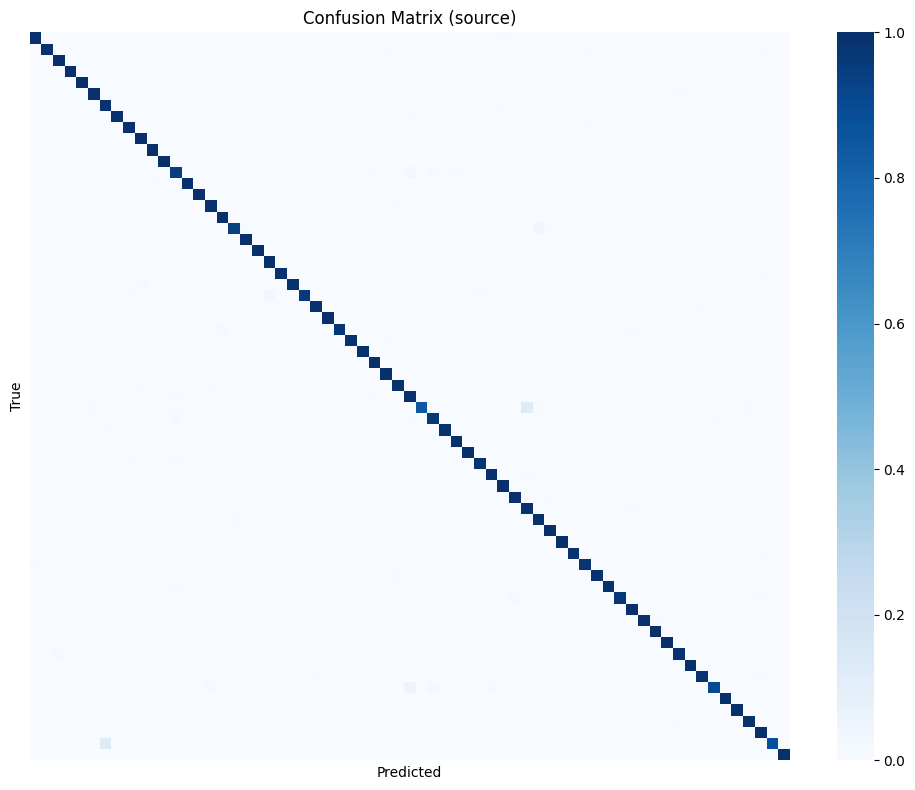

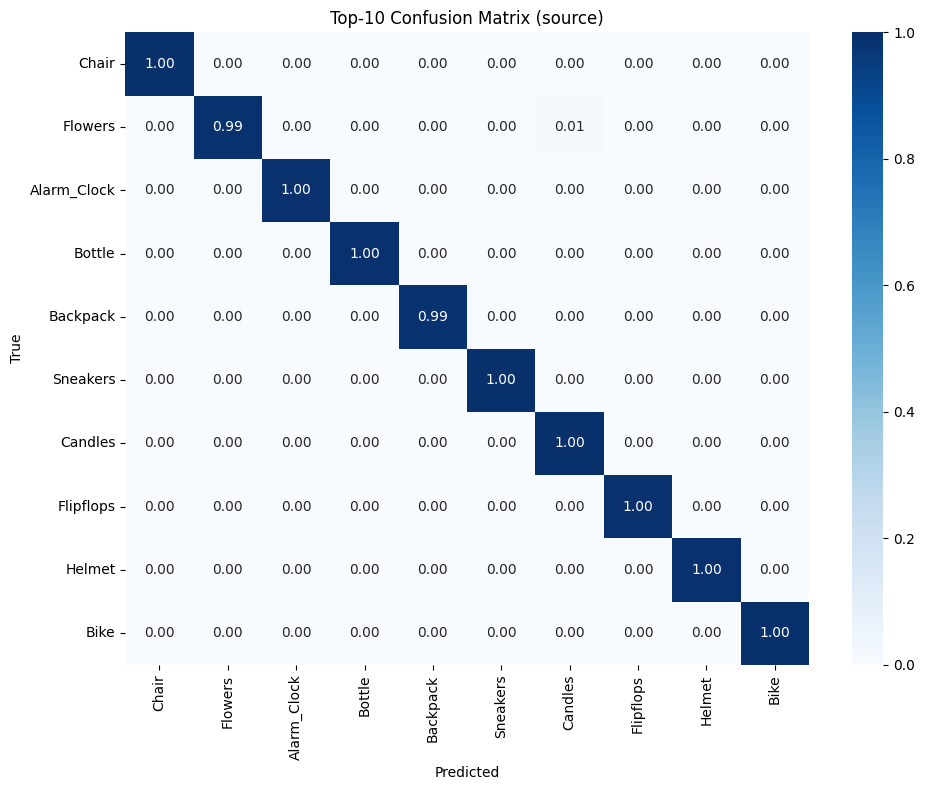


=== TARGET REPORT ===
              precision    recall  f1-score   support

 Alarm_Clock     0.6667    0.5000    0.5714        60
    Backpack     1.0000    0.0714    0.1333        56
   Batteries     0.4872    0.2969    0.3689        64
         Bed     0.7857    0.1122    0.1964        98
        Bike     0.6857    0.7273    0.7059        99
      Bottle     0.6000    0.2727    0.3750        99
      Bucket     0.3434    0.4658    0.3953        73
  Calculator     0.5625    0.7826    0.6545        46
    Calendar     0.2875    0.5897    0.3866        78
     Candles     0.3692    0.2424    0.2927        99
       Chair     0.5287    0.4646    0.4946        99
  Clipboards     0.1724    0.1250    0.1449        40
    Computer     0.3175    0.4040    0.3556        99
       Couch     0.3243    0.1875    0.2376        64
    Curtains     0.5192    0.6429    0.5745        42
   Desk_Lamp     0.0568    0.3171    0.0963        41
       Drill     0.6389    0.4792    0.5476        48
    

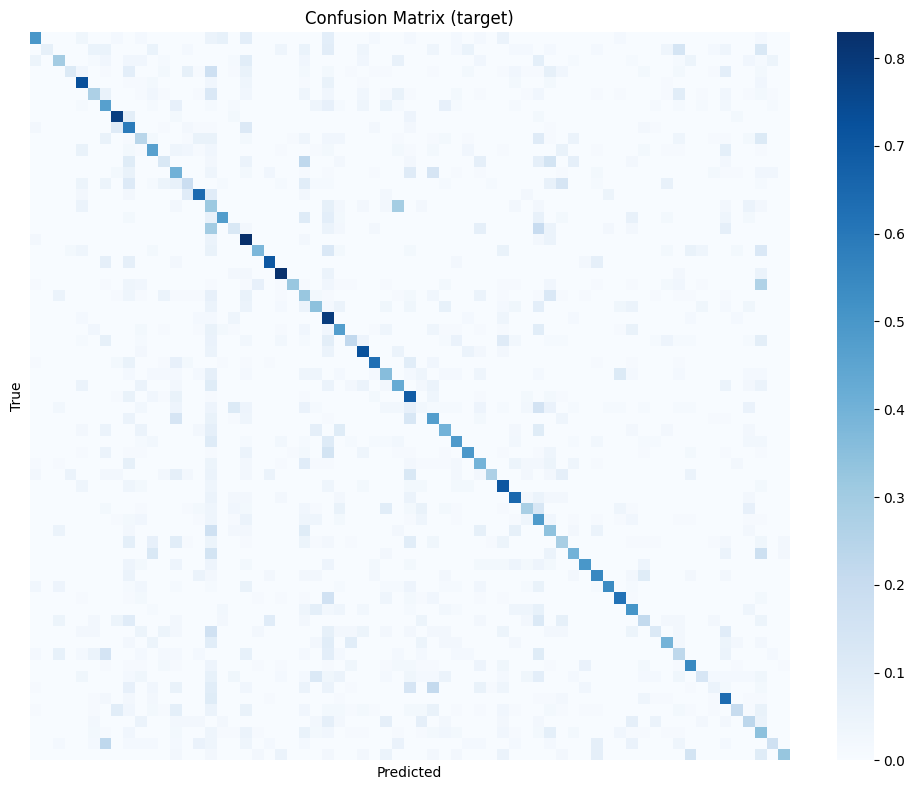

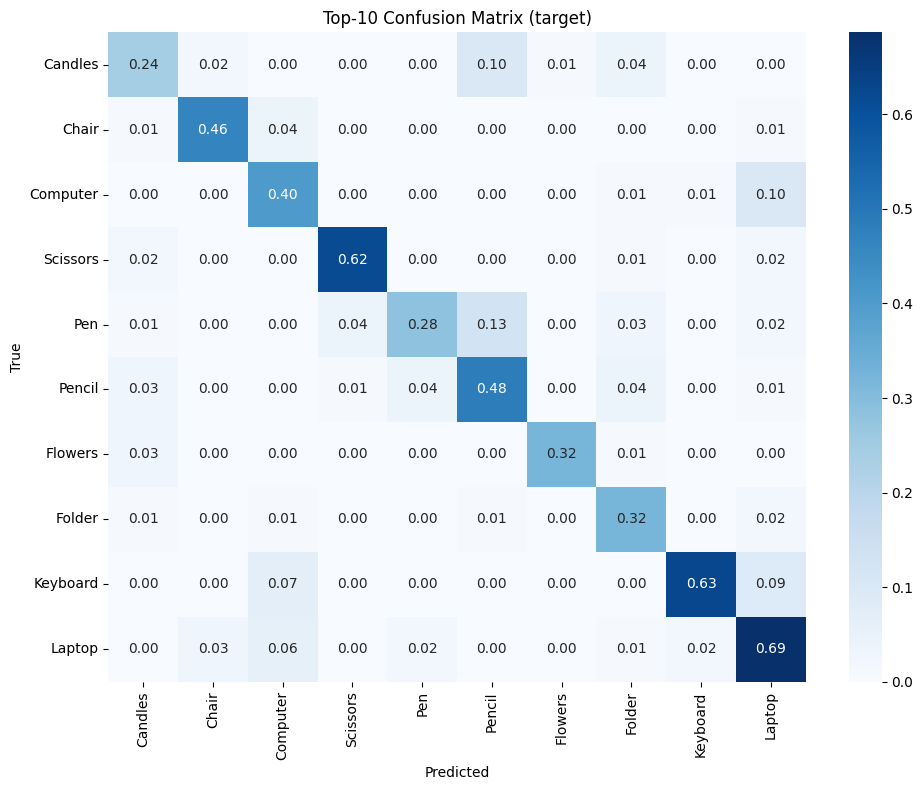

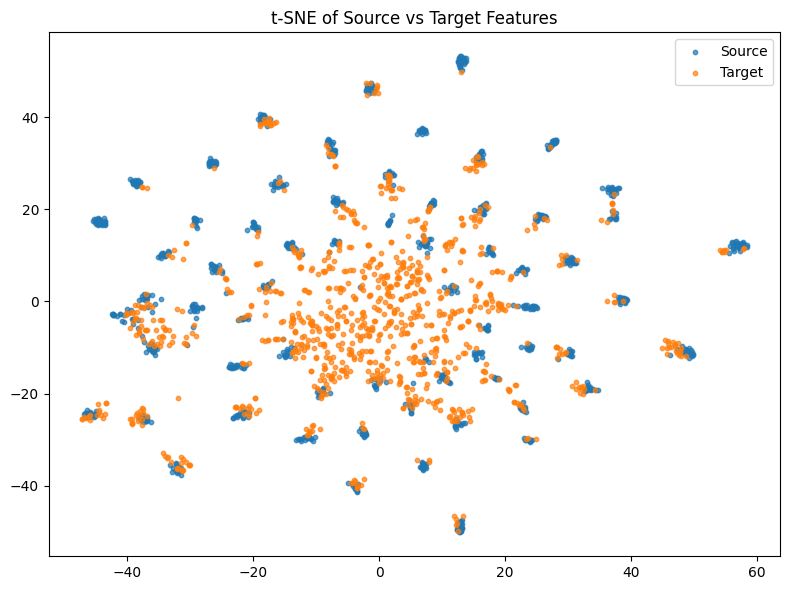

{'tsne': array([[-18.269222  ,   3.2273288 ],
        [ -7.982707  ,  34.26109   ],
        [-11.858106  , -29.508017  ],
        ...,
        [-37.278465  ,  -1.5131406 ],
        [-39.314346  , -26.379349  ],
        [ -0.29378015,  -1.6823312 ]], dtype=float32),
 'source': {'report': '              precision    recall  f1-score   support\n\n Alarm_Clock     0.9876    0.9958    0.9917       239\n    Backpack     1.0000    0.9874    0.9937       239\n   Batteries     0.9871    1.0000    0.9935       153\n         Bed     1.0000    1.0000    1.0000       166\n        Bike     1.0000    1.0000    1.0000       218\n      Bottle     0.9958    0.9958    0.9958       239\n      Bucket     0.8691    0.9940    0.9274       167\n  Calculator     1.0000    0.9947    0.9973       187\n    Calendar     0.9825    0.9941    0.9882       169\n     Candles     0.9830    1.0000    0.9914       231\n       Chair     0.9962    1.0000    0.9981       264\n  Clipboards     1.0000    1.0000    1.0000      

In [86]:
trainer.analysis(src_loader, tgt_loader, class_names= source_ds.classes,random_state=42)